# Setup the Environment

In [8]:
import os
import torch
import model
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Audio, display
from torch.utils import data
from dataloader import MtatDataset
from evaluate import Predict

In [9]:
if not os.path.exists("./results"):
    os.makedirs("./results")

In [10]:
use_cuda = torch.cuda.is_available()
print("Using GPU..." if use_cuda else "Using CPU")

Using GPU...


# Visualize Different Augmentations

In [11]:
dataset = MtatDataset(split='TEST', input_length=59049,aug_types=(True,True,True))
data_org, _ = dataset[0]
display(Audio(data_org, rate=16000))
data_noise_aug, _ = dataset.get_augmented(0,(True,False,False))
display(Audio(data_noise_aug, rate=16000))
data_timeshift_aug, _ = dataset.get_augmented(0,(False,True,False),timeshift_rate=1.1)
display(Audio(data_timeshift_aug, rate=16000))
data_pitchshift_aug, _ = dataset.get_augmented(0,(False,False,True),pitchshift_rate=5)
display(Audio(data_pitchshift_aug, rate=16000))

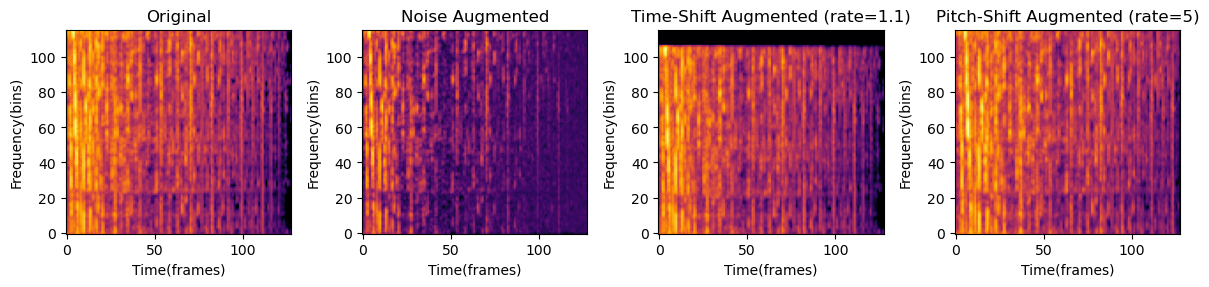

In [12]:
D_org = librosa.feature.melspectrogram(y=data_org, sr=16000, n_mels=128)
log_D_org = librosa.power_to_db(D_org, ref=np.max)

D_noise_aug = librosa.feature.melspectrogram(y=data_noise_aug, sr=16000, n_mels=128)
log_D_noise_aug = librosa.power_to_db(D_noise_aug, ref=np.max)

D_timeshift_aug = librosa.feature.melspectrogram(y=data_timeshift_aug, sr=16000, n_mels=128)
log_D_timeshift_aug = librosa.power_to_db(D_timeshift_aug, ref=np.max)

D_pitchshift_aug = librosa.feature.melspectrogram(y=data_pitchshift_aug, sr=16000, n_mels=128)
log_D_pitchshift_aug = librosa.power_to_db(D_pitchshift_aug, ref=np.max)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
im_org = ax1.imshow(log_D_org.T, cmap='inferno', origin='lower')
ax1.set_title('Original')
ax1.set_xlabel('Time(frames)')
ax1.set_ylabel('Frequency(bins)')

im_noise_aug = ax2.imshow(log_D_noise_aug.T, cmap='inferno', origin='lower')
ax2.set_title('Noise Augmented')
ax2.set_xlabel('Time(frames)')
ax2.set_ylabel('Frequency(bins)')

im_timeshift_aug = ax3.imshow(log_D_timeshift_aug.T, cmap='inferno', origin='lower')
ax3.set_title('Time-Shift Augmented (rate=1.1)')
ax3.set_xlabel('Time(frames)')
ax3.set_ylabel('Frequency(bins)')

im_pitchshift_aug = ax4.imshow(log_D_pitchshift_aug.T, cmap='inferno', origin='lower')
ax4.set_title('Pitch-Shift Augmented (rate=5)')
ax4.set_xlabel('Time(frames)')
ax4.set_ylabel('Frequency(bins)')

plt.tight_layout()
plt.savefig("./results/mel_spectrograms.png", bbox_inches='tight')
plt.show()

# Results on the Unaugmented Test Set

In [16]:
# list of models and augmentations
models = ["fcn","musicnn","crnn","sample","se","short","short_res","hcnn","vit"]
aug_types = ["no_aug", "aug_0.25", "aug_0.5", "aug_0.75", "aug_1.0"]
aug_map = {
    "no_aug":0.0, 
    "aug_0.25":0.25, 
    "aug_0.5":0.5, 
    "aug_0.75":0.75, 
    "aug_1.0":1.0      
}

In [17]:
# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = Predict(model_name, model_path)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_regular.csv", index=False)
# print(results_df)

In [23]:
# load the saved dataframe
df = pd.read_csv('./results/test_scores_regular.csv')
df['Augmentation'] = df['Augmentation'].map(aug_map)

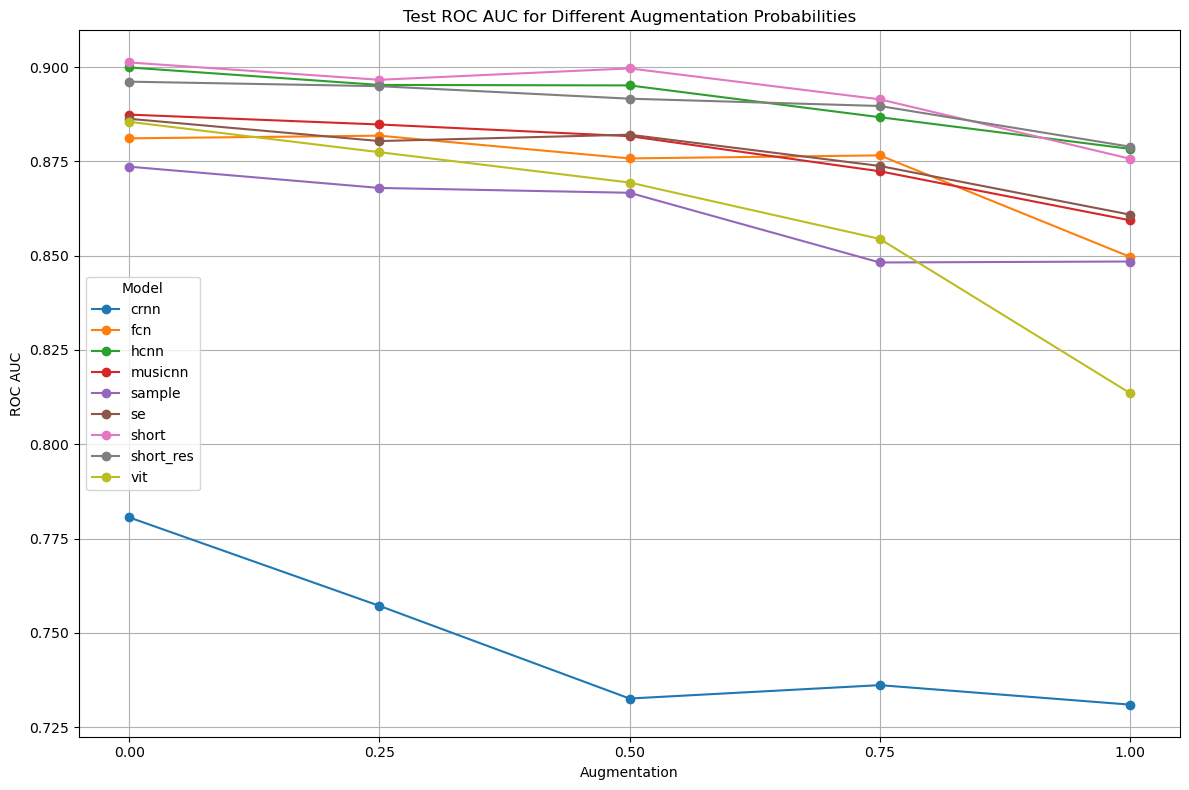

In [29]:
# plot the ROC AUC for varying augmentation probabilities
roc_df = df.pivot(index='Augmentation', columns='Model', values='ROC AUC')

plt.figure(figsize=(12, 8))
for model in roc_df.columns:
    plt.plot(roc_df.index, roc_df[model], marker='o', label=model)

plt.title('Test ROC AUC for Different Augmentation Probabilities')
plt.xlabel('Augmentation')
plt.ylabel('ROC AUC')
plt.xticks(roc_df.index)
plt.legend(title='Model')
plt.grid()
plt.tight_layout()
plt.savefig('./results/test_roc_regular.png')
plt.show()

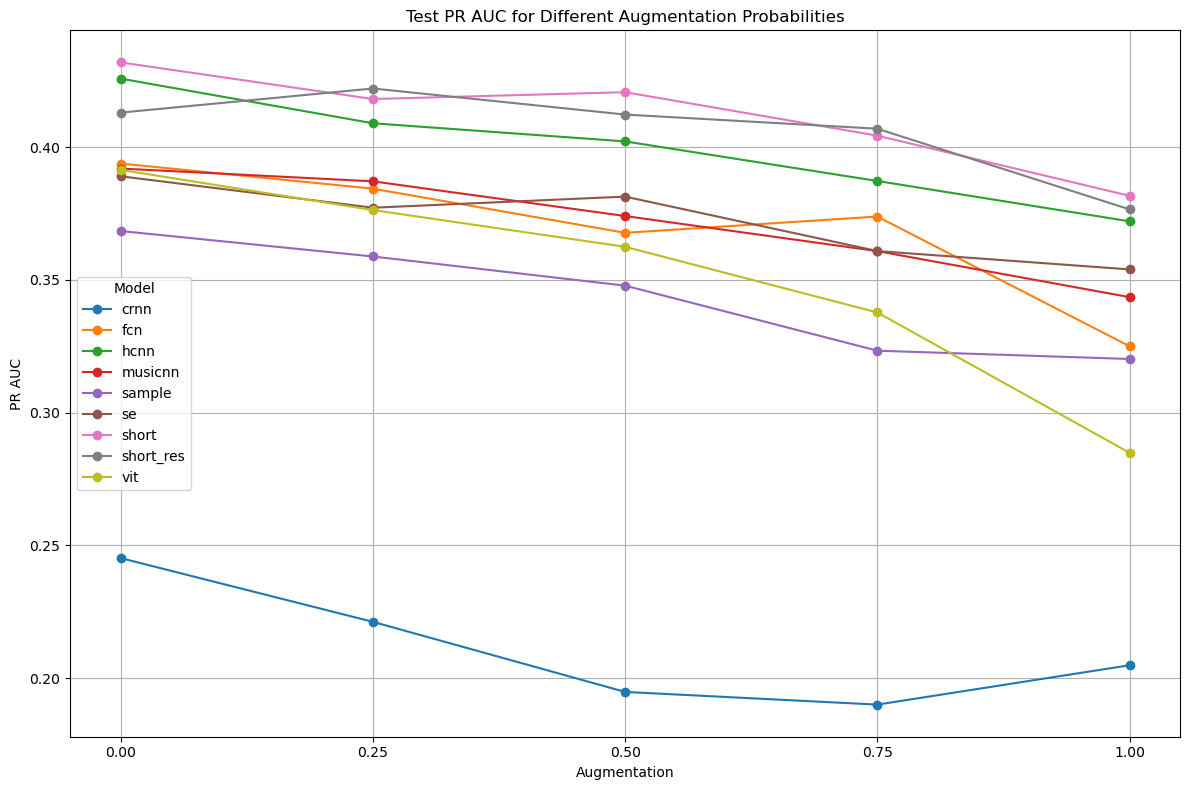

In [30]:
# plot the PR AUC for varying augmentation probabilities
pr_df = df.pivot(index='Augmentation', columns='Model', values='PR AUC')

plt.figure(figsize=(12, 8))
for model in pr_df.columns:
    plt.plot(pr_df.index, pr_df[model], marker='o', label=model)

plt.title('Test PR AUC for Different Augmentation Probabilities')
plt.xlabel('Augmentation')
plt.ylabel('PR AUC')
plt.xticks(pr_df.index)
plt.legend(title='Model')
plt.grid()
plt.tight_layout()
plt.savefig('./results/test_pr_regular.png')
plt.show()

In [ ]:
# TODO: noisy test data to test robustness
# TODO: "best" vit model running for 100 epochs